In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Driving Business Decisions with Data: A/B Testing and Bootstrapping for Conversion Optimization


Written by: Kyle Mair



This analysis uses simulated real-world data from Udacity’s “Analyze A/B Test Results” project, comparing user interactions between a control group (users using an original website version) and an experiment group (users using a new website version). This article is written based off the project I submitted on Udacity’s platform in their course. Source credits and references are listed at the end of this article.



### Introduction
After completing an A/B test, results were collected from two distinct groups: (1) the control group and (2) the treatment group. To determine if their new website feature increased user traffic and engagement, Audacity Inc. needed to test for statistical significance. A sample was gathered and effectively split into the two groups: the control group interacted with the original website, while the treatment group was shown the updated website version with the new feature. All other variables were controlled to ensure the only difference was the version of the website each group used. Those running the experiment measured if users showed a specific action when interacting with their webpage version. If the user displayed this action they were marked down as (converted = 1), and it was considered a successful result. From there, it was my turn to dive into statistical analysis to evaluate both statistical and practical significance—and ultimately help guide the company’s decision-making.


### Analyzing The Dataset
To begin analyzing the results of the A/B test, I started by looking at the dataset. I wanted to see the different columns and values, and the number of rows and proportions of attributes per group. I wanted to see the proportion of users using their version of the website that displayed the desired action of engagement (converted = 1) compared to those that did not (converted = 0). I also checked for any missing values.


---

In [98]:
df = pd.read_csv('ab_data.csv')
df.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


In [99]:
summary_df = pd.DataFrame(data=[[len(df), len(df.query('converted == 1')) / len(df)]],
                          columns=[['Length of Dataset', 'Proportion of users converted']])
summary_df

,Length of Dataset,Proportion of users converted
0,69889,0.130478


In [100]:
df.isnull().any()

country      False
group        False
converted    False
dtype: bool

---

The experiment saw 13% of all participants display the desired action of engagement with the website version they were interacting with regardless of their group. Next, I wanted to add a unique identifying column to the dataset because such a column did not currently exist, then I could search and ensure there were no duplicate rows. I could also observe the different data types of each column in the dataset and see the possible values of the "converted" column.

---

In [101]:
df['id'] = df.index
df.duplicated().any()

False

In [102]:
df.dtypes

country      object
group        object
converted     int64
id            int64
dtype: object

In [103]:
df['converted'].value_counts()

0    60770
1     9119
Name: converted, dtype: int64

---


### Probability

I wanted to look more closely at the proportions that made up each group for which subjects took the desired action with the website version they were given. I took a proportion of all subjects in the experiment regardless of their group, then I took a proportion of each group individually to see the proportion of subjects that took the desired action in the experiment (converted = 1).


---

In [105]:
prob_df = pd.DataFrame(
    data=[[len(df.query('converted == 1')) / len(df),
    len(df.query('group == "control" and converted == 1')) / len(df.query('group == "control"')),
    len(df.query('group == "treatment" and converted == 1')) / len(df.query('group == "treatment"'))]],
    columns=['All Subjects Average Conversion Rate',
             'Average Conversion Rate (Old Website)', 'Average Conversion Rate (New Website)'])

prob_df

,All Subjects Average Conversion Rate,Average Conversion Rate (Old Website),Average Conversion Rate (New Website)
0,0.130478,0.105254,0.155321


In [106]:
obs_diff = (prob_df['Average Conversion Rate (New Website)'] - prob_df['Average Conversion Rate (Old Website)'])[0]
obs_diff

0.050066728877864425

---


Looking at the proportion of subjects in the treatment group that showed the desired action with the new website version (15.5%), the proportion of users that show this same desired action is less with the old website version (10.5%). Here we see this observed difference is 5%.

I wanted to continue looking at different probabilities, like the probability that an individual was in the treatment group.


---

In [107]:
len(df.query('group == "treatment"')) / len(df)

0.5038131894861853

---


We see a probability here of 50% that an individual was in the treatment group. Next, I wanted to check out what different proportions of all individuals were from which countries. I completed this with a pie chart as shown below.


---

Text(0.5, 1.0, 'Proportion of Experimental Subjects By Country')

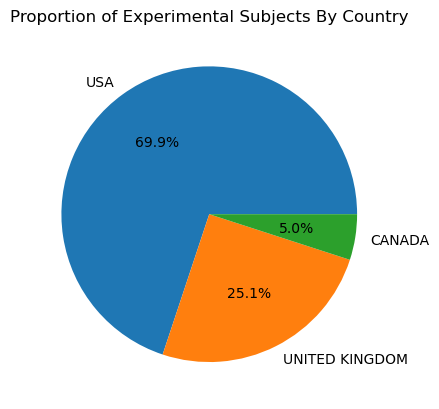

In [113]:
plt.pie(df['country'].value_counts(), labels = ['USA', 'UNITED KINGDOM', 'CANADA'], autopct='%1.1f%%')
plt.title('Proportion of Experimental Subjects By Country')

---


Continuing down the route of different demographics I wanted to check some conditional probability given a subject of the experiment was from a specific country testing the probability of them displaying the conversion action regardless of their group (control & treatment).


---

$P(\text{converted} == 1|\text{country} ==\text{"US"})$ = 0.133


In [80]:
len(df.query('country=="US" and converted == 1')) / len(df.query('country == "US"'))

0.13277379733879222

$P(\text{converted} == 1|\text{country} ==\text{"UK"})$ = 0.125

In [81]:
len(df.query('country=="UK" and converted == 1')) / len(df.query('country == "UK"'))

0.12512107572218106

$P(\text{converted} == 1|\text{country} ==\text{"CA"})$ = 0.125

In [82]:
len(df.query('country=="CA" and converted == 1')) / len(df.query('country == "CA"'))

0.1252866972477064

---


The above conditional probability statistics show that if a given subject is from the United States, they display the converted trait 13.3% of the time on average, while the other countries display it 12.5% of the time on average. So experimental subjects from the United States typically have a higher probability in this category of displaying the desired action of the experiment when interacting with their version of the website, this is not based by experimental groups. This is based by all experimental subjects.


### Analyzing the experiment (A/B Test Results)
The goal with the new feature implemented in the new version of the website is that it leads to a higher user conversion rate than the old version of the website that does not have the new feature. This would setup our null hypothesis as showing that the new version shows a decrease or no change in conversion rate among users. The alternative hypothesis would be set up to show that the new version shows an increase in conversion rate among users. We can notate these hypothesis as:

$H_{0}: p_{treatment} - p_{control} <= 0$

$H_{1}: p_{treatment} - p_{control} > 0$

Here the **$p_{treatment}$** is the converstion rate for the treatment group and **$p_{control}$** is the conversion rate for the control group. When analyzing the test to find if the null hypothesis is rejected or not, I will execute the hypothesis test using bootstrapping. I will start with the observed difference of 5% we calculated earlier.


---

In [83]:
obs_diff

0.050066728877864425

---


Next, I will simulate creating a sampling distribution of the differences in conversion rates between the experiment group and the control group. For each iteration this will calculate a difference that will show if the experiment group had a higher proportion of experimental subjects that converted compared to the control group, or not. The result of all these iterations will be a sampling distribution that will approach a normal distribution shape because of the central limit theorem.


---

In [86]:
p_diffs = []

for i in range(10000):
    bootsample = df.sample(n=df.shape[0], replace=True)
    p_treatment_conv = len(bootsample.query('group == "treatment" and converted == 1')) / len(bootsample.query('group == "treatment"'))
    p_control_conv = len(bootsample.query('group == "control" and converted == 1')) / len(bootsample.query('group == "control"'))
    p_diffs_conv = p_treatment_conv - p_control_conv
    p_diffs.append(p_diffs_conv)

p_diffs = np.array(p_diffs)
p_diffs

array([0.05090708, 0.05536105, 0.04979914, ..., 0.05096004, 0.0509795 ,
       0.04817188])

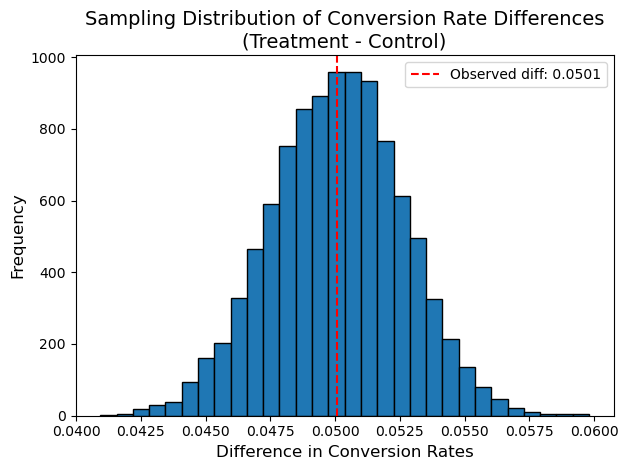

In [122]:
plt.hist(p_diffs, bins=30, edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='--', label=f'Observed diff: {obs_diff:.4f}')
plt.title('Sampling Distribution of Conversion Rate Differences\n(Treatment - Control)', fontsize=14)
plt.xlabel('Difference in Conversion Rates', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('./conversion_chart.png')


---


Above I created (and plotted) a sampling distribution of the average differences between the conversion rates of the experiment group and the control group. I iterated the sampling 10,000 times with replacement. For example, for one iteration I would find the proportion of experimental subjects in the treatment group that converted, and then subtract the proportion of experimental subjects in the control group that converted (𝑝𝑡𝑟𝑒𝑎𝑡𝑚𝑒𝑛𝑡−𝑝𝑐𝑜𝑛𝑡𝑟𝑜𝑙). I did this 10,000 times to end up with a sampling distribution. The evidence here looks strong that even over 10,000 examples there seems to be an increase in conversion rate among the experiment group. The sampling with replacement method here statistically simulates We can strengthen this statement with a 95% confidence interval.


---

In [97]:
low_limit, upper_limit = np.percentile(p_diffs, [2.5,97.5])
low_limit, upper_limit

(0.04497888957956648, 0.05497064318467871)

---


`95% Confidence Interval: (0.04498, 0.05497)`
This confidence interval means that we are 95% confident that the true difference in conversion rates between the treatment and control groups lies between 4.5% and 5.5%. Because this interval does not include a 0% it provides strong statistical evidence that the new website version had a positive effect on user conversion.

This is a strong starting point. The next critical step is to test whether our results are statistically significant enough to reject the null hypothesis by calculating the p-value. The p-value tells us how likely it is to observe our actual result—or something more extreme in favor of the alternative hypothesis—if the null hypothesis were true. To compute this, we simulate a normal distribution centered at zero (the assumed difference under the null hypothesis), using the standard deviation from our sampling distribution. Essentially, we are modeling what the distribution of differences would look like if there were no true effect, which allows us to measure how extreme our observed result really is.



---

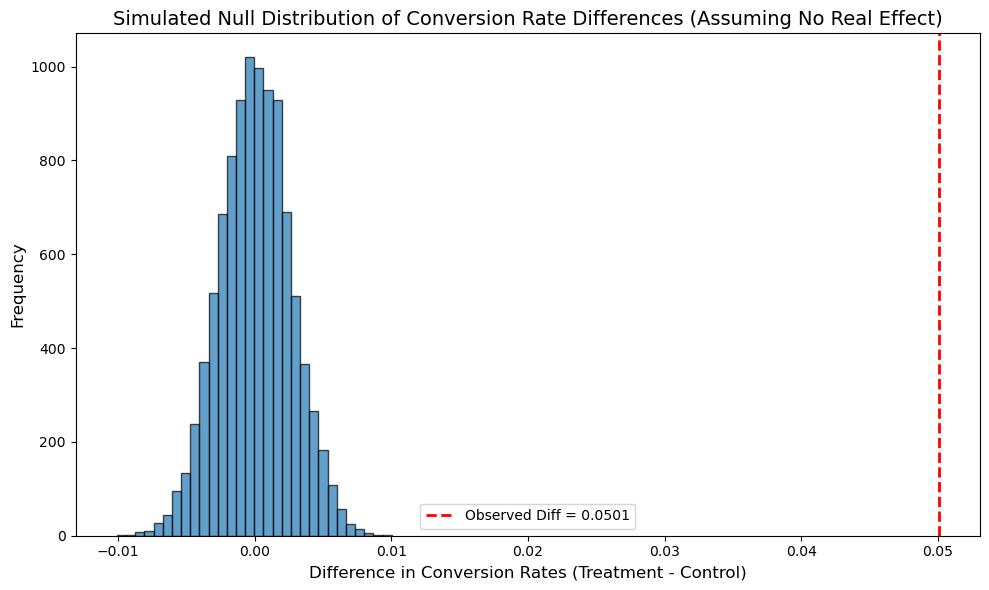

In [125]:
null_vals = np.random.normal(0, np.std(p_diffs), 10000)

plt.figure(figsize=(10,6))
plt.hist(null_vals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=obs_diff, color='red', linestyle='--', linewidth=2, label=f'Observed Diff = {obs_diff:.4f}')
plt.title('Simulated Null Distribution of Conversion Rate Differences (Assuming No Real Effect)', fontsize=14)
plt.xlabel('Difference in Conversion Rates (Treatment - Control)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('./conversion_normal.png')

In [95]:
p_val = len(null_vals[null_vals > obs_diff]) / len(null_vals)
p_val

0.0

---


Above, I simulated our null hypothesis normal distribution values. Then I plotted the point of our observed value on that normal distribution chart, and the proportion of the null hypothesis normal distribution to the right of the observed value would be our p-value. In this instance the chart and the calculation show our 𝑝 = 0. While this is just a simulation, this p-value of 0 shows there is enough evidence to reject the null hypothesis.

Based on the results for this A/B test the statistical significance exists that the new version of the website leads to a higher user conversion rate in the population than the old website version, so I would support Audacity Inc implementing the version of the website with the new feature.


### Conclusion
The A/B test results clearly show that the new website version leads to a statistically significant increase in user conversions. With a 95% confidence interval well above 0% and a p-value near zero, we can confidently reject the null hypothesis. Based on this analysis, I recommend that Audacity Inc. implement the new website feature to enhance user engagement and drive better business outcomes.


### Sources
•	Udacity. (n.d.). Analyze A/B Test Results Project [Course project]. Retrieved from https://www.udacity.com![image-3.png](attachment:image-3.png)